# ICPE 689 Data Science Fundamental for Energy II

Some of the examples and exercises of this course are based on two popular books on data science with Python, [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)
and [the Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/). Several examples in this module are taken from [TensorFlow tutorials](https://www.tensorflow.org/tutorials) and [Google Machine Learning Crash Courses](https://developers.google.com/machine-learning/crash-course).

<span><img src="images/HandsonML.jpg" width="200" /><img src="images/PDSH-cover.png" width="200" /><img src="images/tensorflow-logo.png" width="200" /></span>

## Deep Learning for Multiple Data Types

Deep learning (also known as deep structured learning) is part of a broader family of machine learning methods based on artificial neural networks with representation learning. Learning can be supervised, semi-supervised or unsupervised. This module covers the following topiocs.

1. Convolution Neural Network (CNN) for Computer Vision (CV) and Audio
2. Recurrent Neural Network (RNN), Long Short-Term Memory (LSTM)

[<img src="images/colab-badge.png" width="200"/>](https://colab.research.google.com/github/jtao/AdvancedML/blob/main/DL_for_multiple_data_types.ipynb)

## Convolutional Neural Network (CNN)
* A convolutional neural network (CNN, or ConvNet) is a class of deep neural networks (DNNs), most commonly applied to analyzing visual imagery.

* They are also known as shift invariant or space invariant artificial neural networks (SIANN), based on the shared-weight architecture of the convolution kernels that shift over input features and provide translation equivariant responses.

<center><img src="images/Typical_cnn.png" width="600"/><br/>Credit: Wikipedia.org</center>

In [138]:
# load some basic modules
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from sklearn.datasets import load_sample_image
import warnings
warnings.filterwarnings("ignore")

In [42]:
# define some functions to facilitate plotting
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")
    
def crop(images):
    return images[150:220, 130:250]    

In [43]:
# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

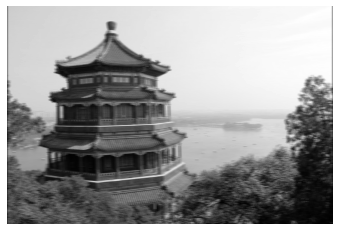

In [44]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off");

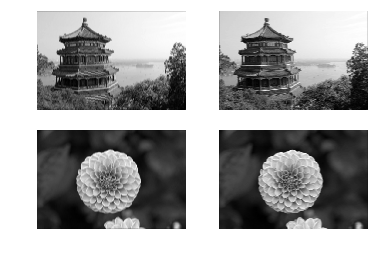

In [4]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

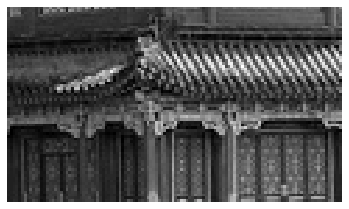

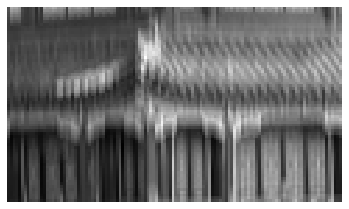

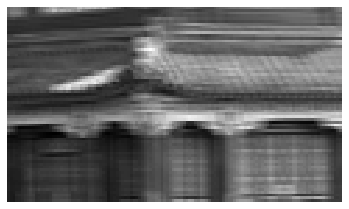

In [45]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

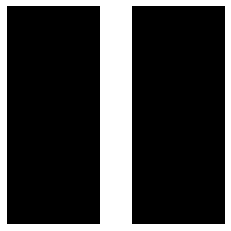

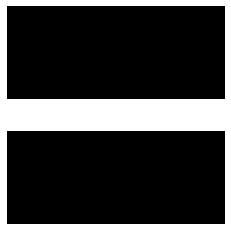

In [46]:
# what does our filters look like?
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

### Convolutional Layer

Using `keras.layers.Conv2D()`

* This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. Finally, if activation is not None, it is applied to the outputs as well.

* When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers, does not include the sample axis), e.g. input_shape=(128, 128, 3) for 128x128 RGB (3 color channels) pictures.

<center><img src="images/CNN_Conv.gif" width="400"/><br/>Credit: Applied Deep Learning | Arden Dertat</center>

In [51]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

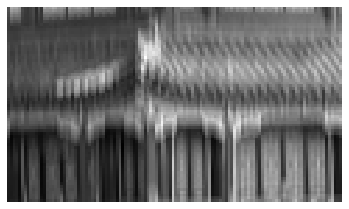

In [48]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

### VALID vs SAME padding

* With "VALID" padding, no "made-up" padding inputs. The layer only uses valid input data (the leftmost in the figure below).
* With "SAME" padding, if you use a stride of 1, the layer's outputs will have the same spatial dimensions as its inputs (the 3rd from the left in the figure below).


<center><img src="images/CNN_padding.gif" width="600"/><br/>Visualization credits: vdumoulin@GitHub</center>


In [40]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Using `"SAME"` padding is equivalent to padding manually using `manual_same_padding()` then using `"VALID"` padding (confusingly, `"VALID"` padding means no padding at all):

In [39]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

### Pooling Layer

Pooling is a form of non-linear down-sampling. There are several non-linear functions to implement pooling, where max pooling is the most common. It partitions the input image into a set of rectangles and, for each such sub-region, outputs the maximum.

Intuitively, the exact location of a feature is less important than its rough location relative to other features. 

<center><img src="images/Max_Pooling.png" width="400"/><br/>Credit: Applied Deep Learning | Arden Dertat</center>

**Max Pooling**

In [54]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [55]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

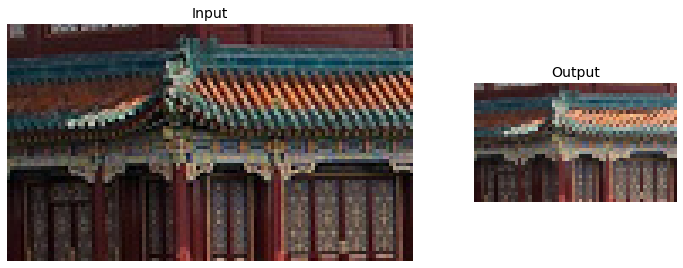

In [57]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off");

**Average pooling**

In [62]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [63]:
output_avg = avg_pool(cropped_images)

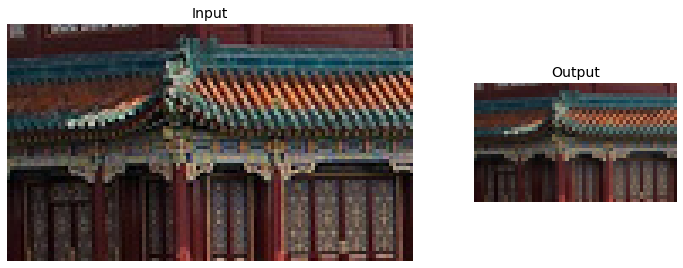

In [64]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

**Global Average Pooling**

In [65]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [66]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

### Example: Tackling Fashion MNIST With a CNN

In [67]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [68]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [69]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 82s 48ms/step - loss: 0.9975 - accuracy: 0.6430 - val_loss: 0.3813 - val_accuracy: 0.8594
Epoch 2/10
1719/1719 [==============================] - 79s 46ms/step - loss: 0.4312 - accuracy: 0.8549 - val_loss: 0.3430 - val_accuracy: 0.8758
Epoch 3/10
1719/1719 [==============================] - 78s 45ms/step - loss: 0.3635 - accuracy: 0.8783 - val_loss: 0.3319 - val_accuracy: 0.8810
Epoch 4/10
1719/1719 [==============================] - 81s 47ms/step - loss: 0.3203 - accuracy: 0.8897 - val_loss: 0.3138 - val_accuracy: 0.8900
Epoch 5/10
1719/1719 [==============================] - 81s 47ms/step - loss: 0.2992 - accuracy: 0.8975 - val_loss: 0.2877 - val_accuracy: 0.8946
Epoch 6/10
1719/1719 [==============================] - 80s 47ms/step - loss: 0.2948 - accuracy: 0.9009 - val_loss: 0.2661 - val_accuracy: 0.9006
Epoch 7/10
1719/1719 [==============================] - 81s 47ms/step - loss: 0.2760 - accuracy: 0.9062 - val_loss: 0.2923 -

**ResNet**
A residual neural network (ResNet) is an artificial neural network (ANN) that jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between. The shortcut connections perform identity mapping, and their outputs are added to the outputs of the stacked layers. 

* ResNets are easy to optimize, but the “plain” networks (that simply stack layers) shows higher training error when the depth increases.
* ResNets can easily gain accuracy from greatly increased depth, producing results which are better than previous networks.
<center><img src="images/Resnet.png" width="400"/><br/>Credit: neurohive.io</center>

In [74]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [75]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [76]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_36 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_16 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_17 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_18 (ResidualUn (None, 56, 56, 64)       

**Using a Pretrained Model**

In [77]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

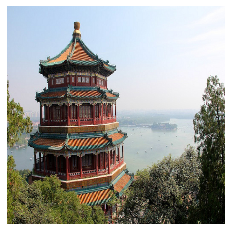

In [78]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


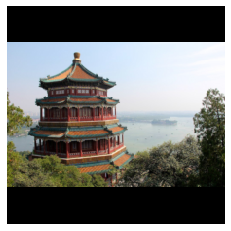

In [83]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

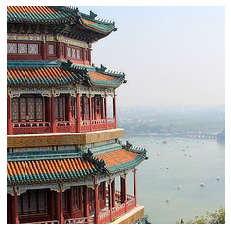

In [82]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

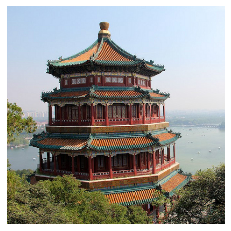

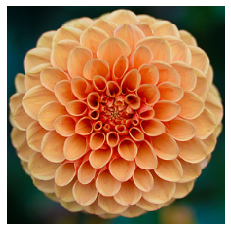

In [84]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [85]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [38]:
Y_proba.shape

(2, 1000)

In [86]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 3us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



**Pretrained Models for Transfer Learning**

You will need to install tensorflow_datasets with `pip install` as shown below

In [95]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dataset tf_flowers downloaded and prepared to /home/jtao/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [96]:
info.splits

{Split('train'): <SplitInfo num_examples=3670, num_shards=2>}

In [97]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [99]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [100]:
n_classes = info.features["label"].num_classes

In [101]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [102]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

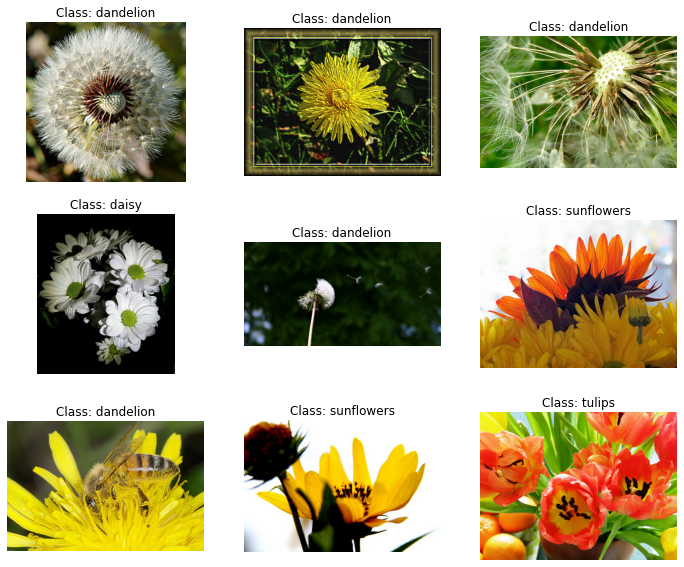

In [104]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off");

In [106]:
#Basic preprocessing:
    
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [107]:
#Slightly fancier preprocessing (but you could add much more data augmentation):
    
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

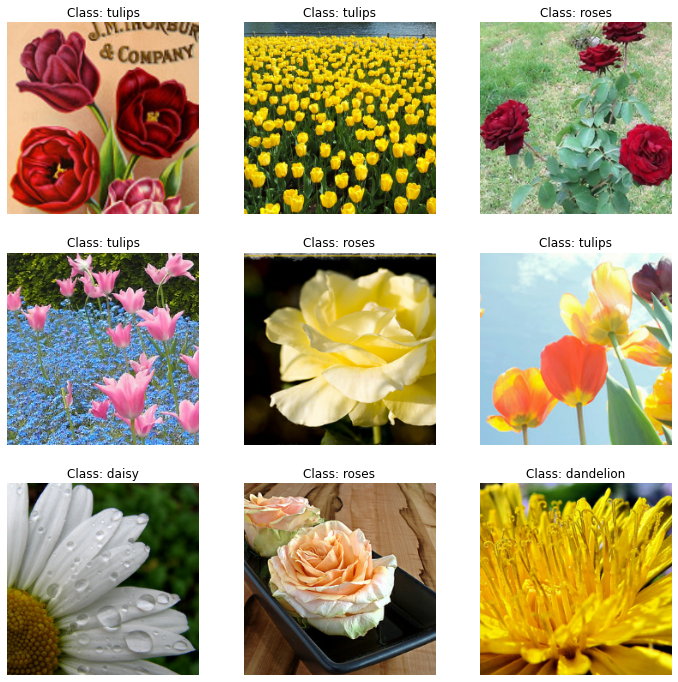

In [108]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

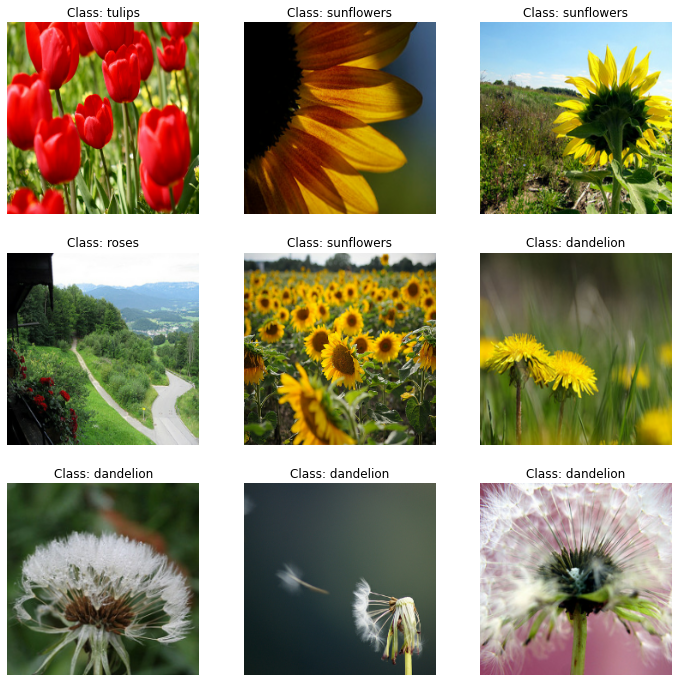

In [109]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [110]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 42s 1us/step 


In [111]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_3
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_82
13 block2_pool
14 batch_normalization_72
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_83
23 block3_pool
24 batch_normalization_73
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_84
33 block4_pool
34 batch_normalization_74
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [112]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 78s 889ms/step - loss: 1.5306 - accuracy: 0.6885 - val_loss: 1.3197 - val_accuracy: 0.8272
Epoch 2/5
86/86 [==============================] - 79s 916ms/step - loss: 0.5847 - accuracy: 0.8929 - val_loss: 0.8632 - val_accuracy: 0.8750
Epoch 3/5
86/86 [==============================] - 79s 915ms/step - loss: 0.3163 - accuracy: 0.9259 - val_loss: 0.7887 - val_accuracy: 0.8548
Epoch 4/5
86/86 [==============================] - 80s 928ms/step - loss: 0.2358 - accuracy: 0.9339 - val_loss: 0.7312 - val_accuracy: 0.8768
Epoch 5/5
86/86 [==============================] - 80s 933ms/step - loss: 0.2093 - accuracy: 0.9406 - val_loss: 0.7783 - val_accuracy: 0.8603


### Example: Simple audio recognition: Recognizing keywords
In this example, we will build a basic speech recognition network that recognizes ten different words.

In [116]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### Import the Speech Commands dataset

You'll write a script to download a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands). The original dataset consists of over 105,000 WAV audio files of people saying thirty different words. This data was collected by Google and released under a CC BY license.

You'll be using a portion of the dataset to save time with data loading. Extract the `mini_speech_commands.zip` and load it in using the `tf.data` API.

In [117]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182083584/182082353 [==============================] - 77s 0us/step


Check basic statistics about the dataset.

In [118]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['no' 'down' 'up' 'right' 'go' 'yes' 'stop' 'left']


Extract the audio files into a list and shuffle it.

In [119]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/right/c4533c47_nohash_0.wav', shape=(), dtype=string)


Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

In [120]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


### Reading audio files and their labels
The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.

To load an audio file, you will use [`tf.audio.decode_wav`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav), which returns the WAV-encoded audio as a Tensor and the sample rate.

A WAV file contains time series data with a set number of samples per second. 
Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, like the files in `mini_speech_commands`, the values range from -32768 to 32767. 
The sample rate for this dataset is 16kHz.
Note that `tf.audio.decode_wav` will normalize the values to the range [-1.0, 1.0].

In [121]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

The label for each WAV file is its parent directory.

In [122]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [123]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

You will now apply `process_path` to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [124]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's examine a few audio waveforms with their corresponding labels.

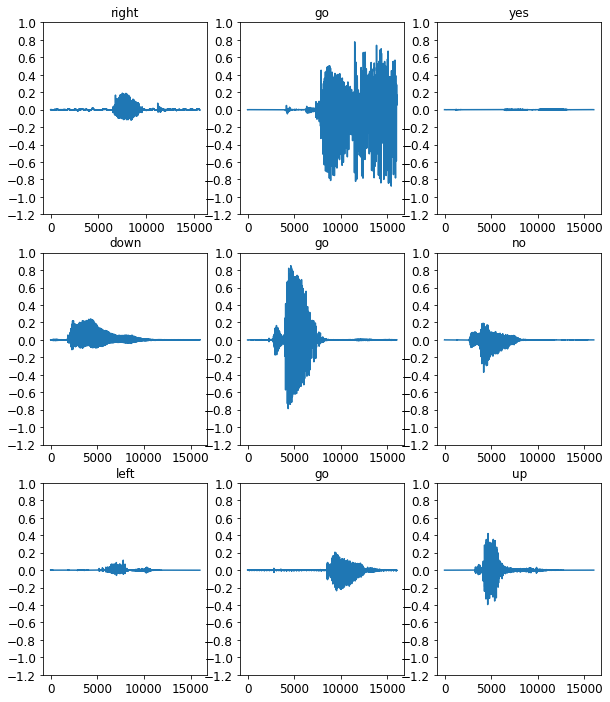

In [126]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label);

### Spectrogram

You'll convert the waveform into a spectrogram, which shows **frequency changes over time** and can be represented as a 2D image. This can be done by applying the **short-time Fourier transform (STFT)** to convert the audio into the time-frequency domain.

* A Fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

* STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`. 

* Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, you can refer to [this video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing. 

* You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.


In [127]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

In [142]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (15604,)
Spectrogram shape: (124, 129)
Audio playback


In [143]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

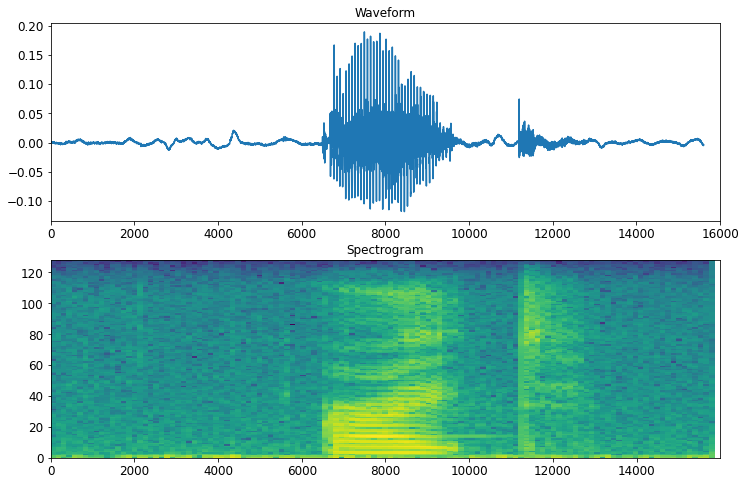

In [144]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [145]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [146]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

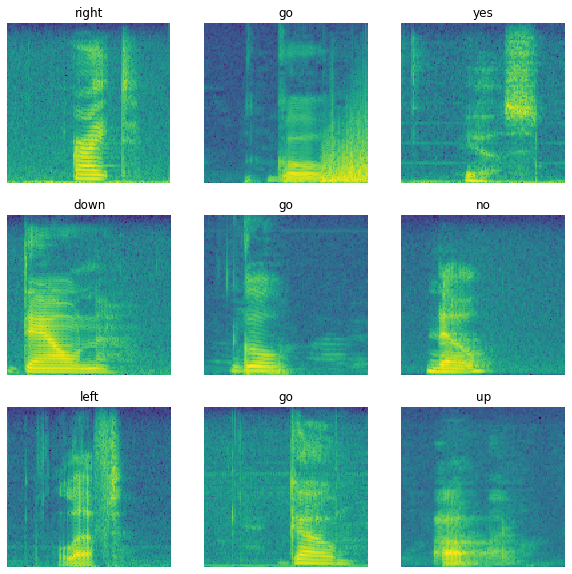

In [149]:
# Examine the spectrogram "images" for different samples of the dataset.
rows = 3; cols = 3; n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off');

### Build and train the model

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [150]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [151]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training.

In [152]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [153]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [157]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

Input shape: (124, 129, 1)


In [158]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)            

In [165]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [166]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 4s 38ms/step - loss: 1.9254 - accuracy: 0.2878 - val_loss: 1.3395 - val_accuracy: 0.5850
Epoch 2/10
100/100 [==============================] - 4s 38ms/step - loss: 1.2776 - accuracy: 0.5479 - val_loss: 0.9447 - val_accuracy: 0.7013
Epoch 3/10
100/100 [==============================] - 4s 38ms/step - loss: 0.9529 - accuracy: 0.6509 - val_loss: 0.7473 - val_accuracy: 0.7613
Epoch 4/10
100/100 [==============================] - 4s 38ms/step - loss: 0.7566 - accuracy: 0.7298 - val_loss: 0.6573 - val_accuracy: 0.8000
Epoch 5/10
100/100 [==============================] - 4s 38ms/step - loss: 0.6467 - accuracy: 0.7705 - val_loss: 0.5979 - val_accuracy: 0.8012
Epoch 6/10
100/100 [==============================] - 4s 38ms/step - loss: 0.5635 - accuracy: 0.7923 - val_loss: 0.5584 - val_accuracy: 0.8263
Epoch 7/10
100/100 [==============================] - 4s 38ms/step - loss: 0.4910 - accuracy: 0.8162 - val_loss: 0.5886 - val_accuracy: 0.8263

Let's check the training and validation loss curves to see how your model has improved during training.

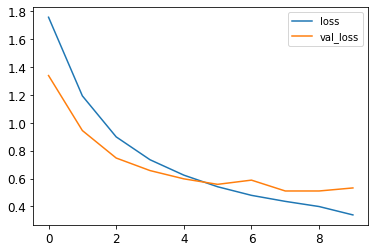

In [167]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

### Evaluate test set performance

Let's run the model on the test set and check performance.

In [168]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [169]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 84%


### Display a confusion matrix

A confusion matrix is helpful to see how well the model did on each of the commands in the test set.

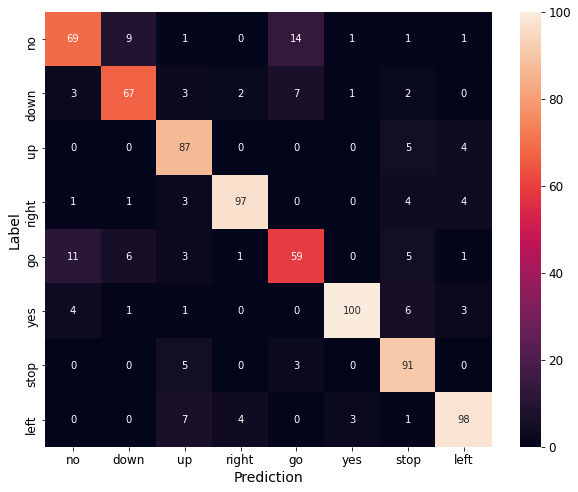

In [170]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no." How well does your model perform?

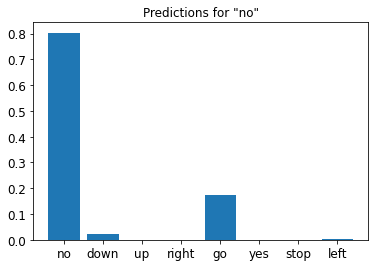

In [171]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()

You can see that your model very clearly recognized the audio command as "no."

### Next steps

This tutorial showed how you could do simple audio classification using a convolutional neural network with TensorFlow and Python.

* To learn how to use transfer learning for audio classification, check out the [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial.

* To build your own interactive web app for audio classification, consider taking the [TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0).

* TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.


## Recurrent Neural Network (RNN)

Not like Sequential neural networks that we have been using, RNNs are networks with loops in them, allowing information to persist.

<center><img src="images/RNN_unrolled.png" width="600"/><br/>Credit: colah.github.io</center>

### Generate the Dataset

In [172]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [173]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [174]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [177]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

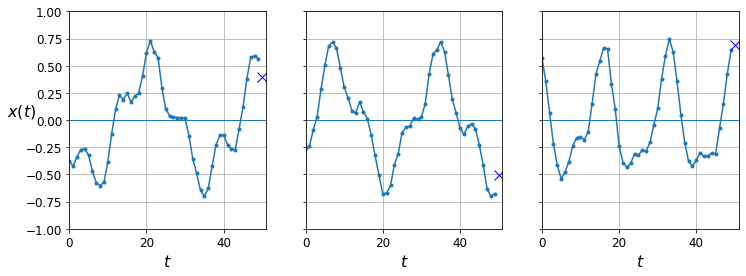

In [178]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None));

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [189]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

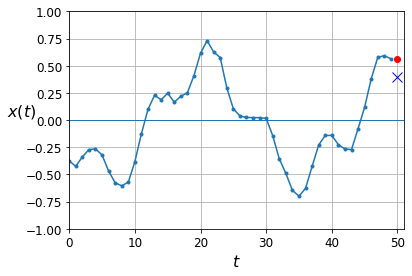

In [180]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [181]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 779us/step - loss: 0.1398 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 523us/step - loss: 0.0443 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 533us/step - loss: 0.0237 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 557us/step - loss: 0.0142 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 514us/step - loss: 0.0110 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 526us/step - loss: 0.0093 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 497us/step - loss: 0.0083 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 486us/step - loss: 0.0074 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 518us/step - loss: 0.0064 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 516us/step - loss: 0.006

In [182]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 352us/step - loss: 0.0042


0.004168087150901556

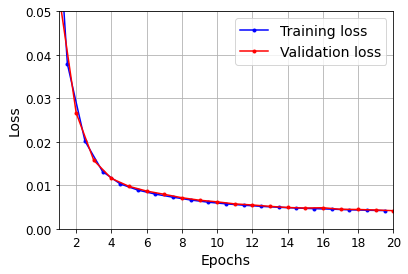

In [183]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

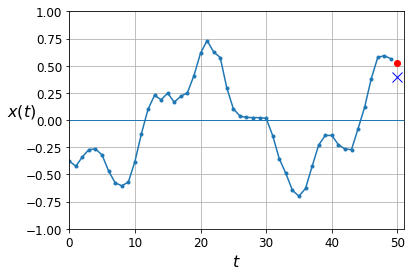

In [193]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0]);

### Using a Simple RNN

In [194]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1554 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0409 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0277 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0117 - val_loss: 0.0110

In [195]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0109


0.010881561785936356

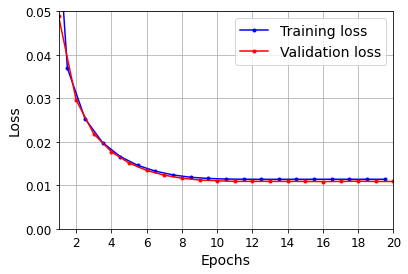

In [196]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

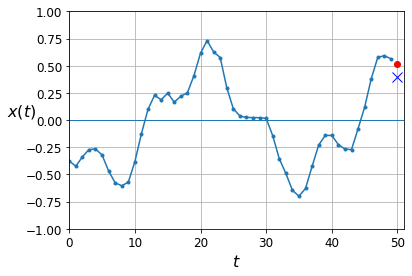

In [198]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0]);

### Deep RNNs

In [199]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 12ms/step - loss: 0.1324 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0035 - val_lo

In [200]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0029


0.0029105644207447767

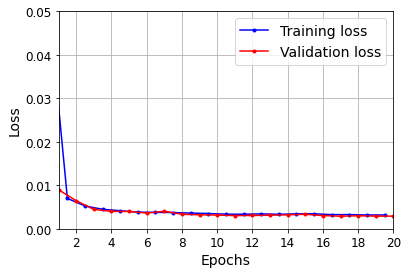

In [201]:
plot_learning_curves(history.history["loss"], history.history["val_loss"]);

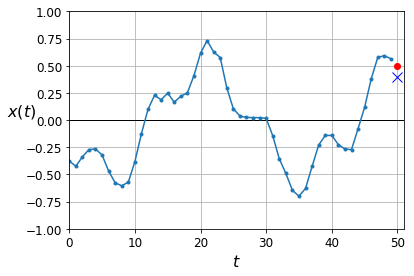

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0]);

Make the second `SimpleRNN` layer return only the last output:

In [202]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 0.0566 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.002

In [21]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 116us/sample - loss: 0.0026


0.0025768046267330646

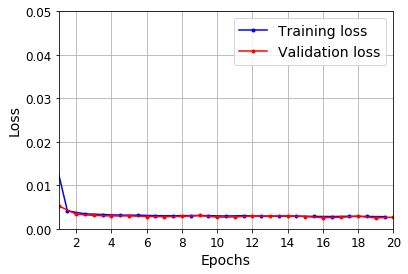

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

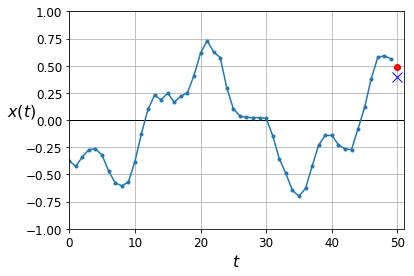

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Deep RNN with Batch Norm

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [211]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [212]:
np.random.seed(42)
tf.random.set_seed(42)

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 0.4750 - last_time_step_mse: 0.5027 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0561 - last_time_step_mse: 0.0468 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0486 - last_time_step_mse: 0.0394 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0443 - last_time_step_mse: 0.0344 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0414 - last_time_step_mse: 0.0315 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0391 - last_time_step_mse: 0.0281 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/219 [=======

### Deep RNNs with Layer Norm

In [213]:
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [214]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 20ms/step - loss: 0.2887 - last_time_step_mse: 0.2855 - val_loss: 0.0755 - val_last_time_step_mse: 0.0713
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0701 - last_time_step_mse: 0.0617 - val_loss: 0.0588 - val_last_time_step_mse: 0.0472
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0574 - last_time_step_mse: 0.0462 - val_loss: 0.0508 - val_last_time_step_mse: 0.0373
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0498 - last_time_step_mse: 0.0366 - val_loss: 0.0452 - val_last_time_step_mse: 0.0311
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0443 - last_time_step_mse: 0.0302 - val_loss: 0.0411 - val_last_time_step_mse: 0.0267
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0401 - last_time_step_mse: 0.0254 - val_loss: 0.0363 - val_last_time_step_mse: 0.0210
Epoch 7/20
219/219 [==

### Creating a Custom RNN Class

In [215]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [216]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 18ms/step - loss: 0.3561 - last_time_step_mse: 0.3517 - val_loss: 0.0769 - val_last_time_step_mse: 0.0716
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0723 - last_time_step_mse: 0.0647 - val_loss: 0.0634 - val_last_time_step_mse: 0.0564
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0614 - last_time_step_mse: 0.0543 - val_loss: 0.0539 - val_last_time_step_mse: 0.0428
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0525 - last_time_step_mse: 0.0410 - val_loss: 0.0477 - val_last_time_step_mse: 0.0355
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0466 - last_time_step_mse: 0.0347 - val_loss: 0.0437 - val_last_time_step_mse: 0.0319
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0428 - last_time_step_mse: 0.0306 - val_loss: 0.0399 - val_last_time_step_mse: 0.0271
Epoch 7/20
219/219 [==

### Long Short-Term Memory (LSTM)
* Long short-term memory (LSTM) is an RNN. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video). 

* A common LSTM unit is composed of a `cell`, an `input gate`, an `output gate` and a `forget gate`. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

* LSTMs were developed to deal with the vanishing gradient problem that can be encountered when training traditional RNNs.

<center><img src="images/LSTM3-chain.png" width="600"/><br/>Credit: colah.github.io</center>

In [217]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 19ms/step - loss: 0.0979 - last_time_step_mse: 0.0877 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0515 - last_time_step_mse: 0.0326 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0407 - last_time_step_mse: 0.0196 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0356 - last_time_step_mse: 0.0156 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0330 - last_time_step_mse: 0.0138 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0313 - last_time_step_mse: 0.0124 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [==

In [218]:
model.evaluate(X_valid, Y_valid)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 4ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788681253790855, 0.008560795336961746]

In [220]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

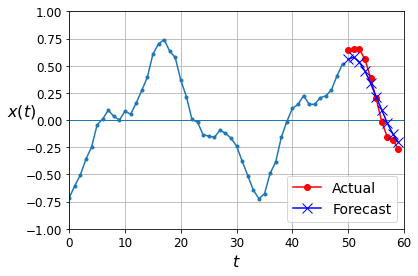

In [221]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### Gated Recurrent Units (GRUs)

* GRU is a variation of LSTM, introduced by Cho, et al. (2014). It combines the `forget` and `input gates` into a single `update gate`. 

* It also merges the cell state and hidden state, and makes some other changes. 

* The resulting model is simpler than standard LSTM models, and has been growing increasingly popular.

<center><img src="images/LSTM3-var-GRU.png" width="600"/><br/>Credit: colah.github.io</center>

In [222]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 22ms/step - loss: 0.0995 - last_time_step_mse: 0.0940 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0495 - last_time_step_mse: 0.0383 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 4s 21ms/step - loss: 0.0432 - last_time_step_mse: 0.0321 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0379 - last_time_step_mse: 0.0261 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0333 - last_time_step_mse: 0.0192 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0310 - last_time_step_mse: 0.0158 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [==

63/63 [==============================] - 0s 4ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


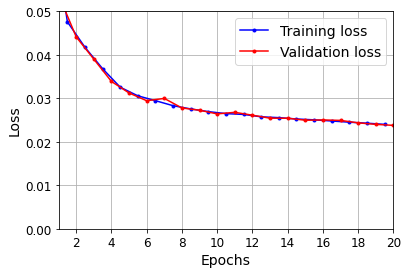

In [224]:
model.evaluate(X_valid, Y_valid)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [55]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

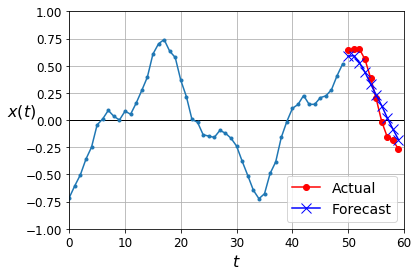

In [56]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()